In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
from tqdm import tqdm
import time
import seaborn as sns
%matplotlib inline

/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import os
USE_GPU = True
os.environ['CUDA_VISIBLE_DEVICES'] = '3' if USE_GPU else ''
EPS = 1e-15

In [3]:
#lpmt_hits = pd.read_hdf('../data/lpmt_hits.h5', mode='r') 
#spmt_hits = pd.read_hdf('../data/spmt_hits.h5', mode='r')
#lpmt_pos = pd.read_csv('data/lpmt_pos.csv') 
#spmt_pos = pd.read_csv('data/spmt_pos.csv') 
#true_info = pd.read_csv('data/true_info.csv') 
train = pd.read_hdf('../data/phase1/train_data_ph1.h5', mode='r') 
validation = pd.read_hdf('../data/phase1/validation_data_ph1.h5', mode='r') 
test = pd.read_hdf('../data/phase1/test_data_ph1.h5', mode='r') 

In [67]:
true_info = pd.read_hdf('../data/phase1/true_data_ph1.h5', mode='r') 

In [4]:
import os
import psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss)

7640375296


In [5]:
train.head() # spmt_hits.head() 

,event,hitTime,pmtID,pmt_x,pmt_y,pmt_z,isLarge,E,R,x,y,z
0,0,24.005239,8753,11456.047,15404.693,307.27652,True,4.747791,14610.378,8290.779,11995.618,911.74286
1,0,24.081249,7872,10957.978,15623.919,2110.89580,True,4.747791,14610.378,8290.779,11995.618,911.74286
2,0,24.498110,8531,9898.779,16434.060,758.81110,True,4.747791,14610.378,8290.779,11995.618,911.74286
3,0,24.558104,8078,10321.058,16104.590,1660.70450,True,4.747791,14610.378,8290.779,11995.618,911.74286
4,0,24.561638,8301,11434.742,15376.045,1209.92570,True,4.747791,14610.378,8290.779,11995.618,911.74286


In [69]:
true_info.head()

,evtID,E,R
2,2,6.823932,14573.132
6,6,7.886344,16146.320
8,8,6.640760,8583.734
13,13,3.580564,16082.676
14,14,0.835570,12824.286


# CatBoost

In [19]:
result = []

for name, group in train.groupby("event"):
    result.append({
        "evtID" : name, 
        "E": group['E'].mean(),
        "R": group['R'].mean(),
        "N": len(group),
        "m_x": group['pmt_x'].mean(),
        "m_y": group['pmt_y'].mean(),
        "m_z": group['pmt_z'].mean(),
        "m_time" : group['hitTime'].mean() - group['hitTime'].min()
    })

In [20]:
train_df = pd.DataFrame.from_records(result)

In [58]:
train_df.head()

,E,N,R,evtID,m_time,m_x,m_y,m_z
0,4.747791,8371,14610.378,0,71.137667,6742.747754,9929.261316,767.530051
1,3.919721,6716,14630.141,1,74.956280,9148.488313,4254.463594,-5668.030986
2,3.765940,6172,16820.080,3,87.906531,-1500.403105,-11539.483607,2423.068899
3,3.217473,5423,13026.938,4,72.440228,-7100.159824,709.128010,7903.695198
4,7.360527,12314,15190.775,5,73.104454,3216.086416,7470.465446,8721.292460


In [22]:
from catboost import Pool, CatBoostRegressor

/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)


In [54]:
train_pool = Pool(train_df[["N", "m_time", "m_x", "m_y", "m_z"]].values, 
                  train_df["E"].values)

In [77]:
model = CatBoostRegressor(iterations=200, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE')

In [78]:
model.fit(train_pool, verbose=True)

Borders generated
0:	learn 5.624809909passed: 0.00207 sec	total: 623ms	remaining: 2m 3s
1:	learn 5.10219303passed: 0.0062 sec	total: 630ms	remaining: 1m 2s
2:	learn 4.61537744passed: 0.00261 sec	total: 633ms	remaining: 41.6s
3:	learn 4.195595076passed: 0.00219 sec	total: 636ms	remaining: 31.2s
4:	learn 3.816040241passed: 0.00162 sec	total: 638ms	remaining: 24.9s
5:	learn 3.458831564passed: 0.00222 sec	total: 640ms	remaining: 20.7s
6:	learn 3.132677488passed: 0.00149 sec	total: 642ms	remaining: 17.7s
7:	learn 2.837022462passed: 0.00158 sec	total: 644ms	remaining: 15.5s
8:	learn 2.575101319passed: 0.00192 sec	total: 647ms	remaining: 13.7s
9:	learn 2.338604299passed: 0.00151 sec	total: 649ms	remaining: 12.3s
10:	learn 2.13132785passed: 0.00196 sec	total: 651ms	remaining: 11.2s
11:	learn 1.934581404passed: 0.00297 sec	total: 655ms	remaining: 10.3s
12:	learn 1.7592955passed: 0.00167 sec	total: 657ms	remaining: 9.45s
13:	learn 1.602740439passed: 0.00147 sec	total: 659ms	remaining: 8.75s
14:	

175:	learn 0.2933452821passed: 0.00295 sec	total: 1.02s	remaining: 139ms
176:	learn 0.2926238439passed: 0.00169 sec	total: 1.02s	remaining: 133ms
177:	learn 0.292305145passed: 0.00167 sec	total: 1.02s	remaining: 127ms
178:	learn 0.2919328899passed: 0.00163 sec	total: 1.03s	remaining: 121ms
179:	learn 0.2917728761passed: 0.00173 sec	total: 1.03s	remaining: 114ms
180:	learn 0.2914015892passed: 0.00166 sec	total: 1.03s	remaining: 108ms
181:	learn 0.2912338975passed: 0.00179 sec	total: 1.03s	remaining: 102ms
182:	learn 0.2910569667passed: 0.00166 sec	total: 1.03s	remaining: 96.2ms
183:	learn 0.2909091906passed: 0.00166 sec	total: 1.04s	remaining: 90.3ms
184:	learn 0.2907985173passed: 0.00171 sec	total: 1.04s	remaining: 84.4ms
185:	learn 0.2906135457passed: 0.00167 sec	total: 1.04s	remaining: 78.5ms
186:	learn 0.2903117171passed: 0.00166 sec	total: 1.04s	remaining: 72.6ms
187:	learn 0.2901060539passed: 0.00167 sec	total: 1.05s	remaining: 66.8ms
188:	learn 0.2898449363passed: 0.00168 sec	tot

In [88]:
train_pool_R = Pool(train_df[["N", "m_time", "m_x", "m_y", "m_z"]].values, 
                  train_df["R"].values)

In [89]:
model.fit(train_pool_R, verbose=True)

Borders generated
0:	learn 12416.24733passed: 0.00624 sec	total: 128ms	remaining: 25.5s
1:	learn 11224.34754passed: 0.00213 sec	total: 131ms	remaining: 12.9s
2:	learn 10148.17714passed: 0.00351 sec	total: 135ms	remaining: 8.85s
3:	learn 9178.123159passed: 0.00329 sec	total: 139ms	remaining: 6.79s
4:	learn 8338.317493passed: 0.00181 sec	total: 141ms	remaining: 5.49s
5:	learn 7546.019576passed: 0.00188 sec	total: 143ms	remaining: 4.63s
6:	learn 6863.307854passed: 0.00158 sec	total: 145ms	remaining: 4s
7:	learn 6272.346723passed: 0.0015 sec	total: 147ms	remaining: 3.53s
8:	learn 5696.261215passed: 0.00144 sec	total: 149ms	remaining: 3.16s
9:	learn 5177.422402passed: 0.00144 sec	total: 151ms	remaining: 2.87s
10:	learn 4713.464238passed: 0.00144 sec	total: 153ms	remaining: 2.62s
11:	learn 4301.93063passed: 0.00155 sec	total: 155ms	remaining: 2.42s
12:	learn 3940.748715passed: 0.00144 sec	total: 157ms	remaining: 2.25s
13:	learn 3620.905436passed: 0.00143 sec	total: 158ms	remaining: 2.1s
14:	

179:	learn 820.9411188passed: 0.00234 sec	total: 534ms	remaining: 59.3ms
180:	learn 819.1420235passed: 0.00158 sec	total: 536ms	remaining: 56.2ms
181:	learn 817.4492661passed: 0.00147 sec	total: 537ms	remaining: 53.2ms
182:	learn 815.3842127passed: 0.00145 sec	total: 539ms	remaining: 50.1ms
183:	learn 813.6268557passed: 0.0015 sec	total: 541ms	remaining: 47.1ms
184:	learn 811.723988passed: 0.0015 sec	total: 543ms	remaining: 44ms
185:	learn 809.6458465passed: 0.00172 sec	total: 545ms	remaining: 41.1ms
186:	learn 807.1877133passed: 0.00151 sec	total: 547ms	remaining: 38ms
187:	learn 805.1389722passed: 0.00144 sec	total: 549ms	remaining: 35.1ms
188:	learn 802.993288passed: 0.00164 sec	total: 551ms	remaining: 32.1ms
189:	learn 801.4966299passed: 0.00145 sec	total: 553ms	remaining: 29.1ms
190:	learn 799.732236passed: 0.00151 sec	total: 555ms	remaining: 26.2ms
191:	learn 797.5273676passed: 0.00162 sec	total: 557ms	remaining: 23.2ms
192:	learn 795.3165721passed: 0.00244 sec	total: 560ms	remai

In [92]:
model.score(train_pool_R, train_df["R"].values)

612418.011793911

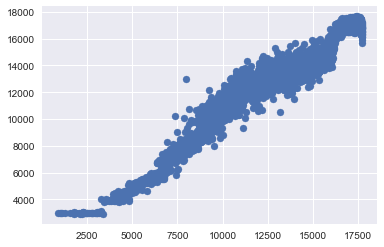

In [93]:
plt.scatter(train_df["R"].values, model.predict(train_pool_R) )

In [80]:
model.score(train_pool, train_df["E"].values)

0.082631167740254

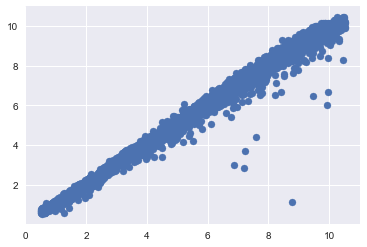

In [81]:
plt.scatter(train_df["E"].values, model.predict(train_pool) )

In [82]:
test.head()

,event,hitTime,pmtID,pmt_x,pmt_y,pmt_z,isLarge,x,y,z
15087,2,23.950851,317805,18378.736,-5522.8594,600.07214,False,14063.338,-3812.854,246.6528
15088,2,24.103539,8935,18385.363,-5524.8510,307.27652,True,14063.338,-3812.854,246.6528
15089,2,24.150829,8937,18663.992,-4494.5503,307.27652,True,14063.338,-3812.854,246.6528
15090,2,24.302891,8936,18531.840,-5011.6370,307.27652,True,14063.338,-3812.854,246.6528
15091,2,24.326164,8938,18781.719,-3973.9895,307.27652,True,14063.338,-3812.854,246.6528


In [83]:
result = []

for name, group in test.groupby("event"):
    result.append({
        "evtID" : name, 
        "N": len(group),
        "m_x": group['pmt_x'].mean(),
        "m_y": group['pmt_y'].mean(),
        "m_z": group['pmt_z'].mean(),
        "m_time" : group['hitTime'].mean() - group['hitTime'].min()
    })

In [84]:
test_df = pd.DataFrame.from_records(result)
test_df = test_df.merge(true_info, on="evtID")

In [94]:
test_df.head()

,N,evtID,m_time,m_x,m_y,m_z,E,R
0,11635,2,72.473969,11465.888473,-3298.430170,215.455769,6.823932,14573.132
1,12948,6,78.344905,1265.835589,-9412.370616,-7289.322666,7.886344,16146.320
2,10196,8,70.606293,3924.965117,-1605.223731,-5210.235467,6.640760,8583.734
3,6268,13,77.589890,-1473.141103,8235.507597,8698.244991,3.580564,16082.676
4,1745,14,77.008743,-1989.257786,1192.279533,-9695.191418,0.835570,12824.286


In [85]:
test_pool = Pool(test_df[["N", "m_time", "m_x", "m_y", "m_z"]].values,
                test_df["E"].values)

In [86]:
model.score(test_pool, test_df["E"].values)

0.16057506513952272

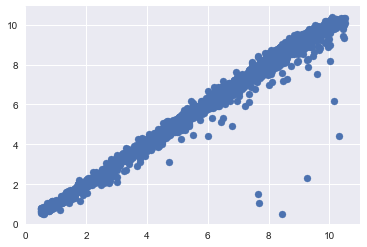

In [87]:
plt.scatter(test_df["E"].values, model.predict(test_pool))